# Car Insurance Quote Binding Prediction Project
This notebook explores a dataset of car insurance quotes to build predictive models that estimate whether a quote leads to a bound insurance policy (the target variable `IS_BOUND`). The task is a binary classification problem where `1` indicates that the policy was bound and `0` otherwise.

We follow a structured approach:
**Exploratory Data Analysis (EDA)** – examined the data structure, missingness patterns, distributions, and class balance.

**Data Cleaning and Feature Engineering** – handled missing values and outliers, engineered meaningful features, and encoded categorical variables.

**Modeling** – trained two models (regularized logistic regression and random forest) using GridSearchCV for hyperparameter tuning, followed by an additional cross-validation step to optimize the decision threshold according to the business objective.

**Model Evaluation** – plotted ROC-AUC curves and compared model performance to select the best-performing model.


# 1. Data Preprocessing

## Data Loading and Initial Preview

In [ ]:
# Import libraries
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

pd.set_option("display.max_rows", None)

In [ ]:
# Load the training dataset
# Root directory
BASE_DIR = Path.cwd()

# Build the full path to the Excel file in a reproducible way
file_path =  BASE_DIR/"data"/"Project2_Training.xlsx"
file_path_test = BASE_DIR/"data"/"Project2_Test.xlsx"

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)
df_test = pd.read_excel(file_path_test)

In [ ]:
#Use the columns of training dataset  # ***UPDATED***
columns = list(df.columns)
columns.remove("IS_BOUND")
df_test.columns = columns

In [ ]:
# Display basic information
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (101891, 26)


,QUOTEDATE,VEHICLEYEAR,VEHICLEMAKE,VEHICLEMODEL,ANNUAL_KM,COMMUTE_DISTANCE,MARKING_SYSTEM,TRACKING_SYSTEM,VEHICLE_OWNERSHIP,VEHICLE_VALUE,...,YEARS_AS_PRINCIPAL_DRIVER,MULTI_PRODUCT,MARITAL_STATUS,OCCUPATION,CONVICTION_COUNT_MINOR_3YRS,CONVICTION_COUNT_MAJOR_3YRS,CONVICTION_COUNT_CRIMINAL_3YRS,ASSIGNED_LOSSES_PD_5YRS,SUSPENSION_COUNT,IS_BOUND
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,10000.0,NaN,NaN,NaN,Owned,3000.0,...,10.0,No,Married,Trades,0,0,0,0,0,0
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,20000.0,NaN,NaN,NaN,Owned,1.0,...,NaN,No,Married,Not Known,0,0,0,0,0,0
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,15000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,No,Single,Not Known,0,0,0,0,0,0
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,30000.0,30.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0


In [ ]:
print("\nData types:")
print(df.dtypes)


Data types:
QUOTEDATE                         datetime64[ns]
VEHICLEYEAR                                int64
VEHICLEMAKE                               object
VEHICLEMODEL                              object
ANNUAL_KM                                float64
COMMUTE_DISTANCE                         float64
MARKING_SYSTEM                            object
TRACKING_SYSTEM                           object
VEHICLE_OWNERSHIP                         object
VEHICLE_VALUE                            float64
VEHICLEUSE                                object
GENDER                                    object
YEAR_OF_BIRTH                              int64
POSTAL_CODE                               object
AREA_CODE                                 object
YEARS_LICENSED                           float64
YEARS_AS_PRINCIPAL_DRIVER                float64
MULTI_PRODUCT                             object
MARITAL_STATUS                            object
OCCUPATION                                object
CONVICT

## Analyzing Missing Values and Target Distribution

In [ ]:
# Calculate the number of missing values in each column
missing_count = df.isnull().sum()

# Calculate the percentage of missing values in each column
missing_pct = df.isnull().mean() * 100

# Combine both into a single DataFrame for easy viewing
missing_summary = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Percent": missing_pct,
})

# Sort by highest percentage of missing values
missing_summary = missing_summary.sort_values(by="Missing_Percent", ascending=False)

# Print the full summary
print("Summary of missing values (count + percentage):\n")
print(missing_summary)

Summary of missing values (count + percentage):

                                Missing_Count  Missing_Percent
TRACKING_SYSTEM                        101887        99.996074
MARKING_SYSTEM                         101866        99.975464
YEARS_AS_PRINCIPAL_DRIVER              101279        99.399358
VEHICLE_OWNERSHIP                       76450        75.031161
VEHICLE_VALUE                           64673        63.472731
COMMUTE_DISTANCE                        35413        34.755768
YEARS_LICENSED                              8         0.007852
GENDER                                      5         0.004907
OCCUPATION                                  1         0.000981
ANNUAL_KM                                   1         0.000981
VEHICLEMODEL                                0         0.000000
VEHICLEMAKE                                 0         0.000000
QUOTEDATE                                   0         0.000000
VEHICLEYEAR                                 0         0.000000
POSTAL

### Missing Value Treatment Strategy

After carefully reviewing each feature and its missingness pattern, and considering both the insurance context and the percentage of missing values, we decided to take the following actions in the data-cleaning stage:

1. **TRACKING_SYSTEM, MARKING_SYSTEM, YEARS_AS_PRINCIPAL_DRIVER**  
   These features have more than 99 percent missing values. They are so rare that the model cannot reliably learn any pattern from them, so we removed them from the dataset.

2. **VEHICLE_OWNERSHIP**  
   Although 75 percent of the values are missing, this feature may still influence binding decisions. It is possible that customers who skip this field behave differently during the quoting process. We keep this feature and impute missing values with a new category, **"Unknown."**

3. **VEHICLE_VALUE**  
   Nearly 63 percent of values are missing, but this feature is important for insurance quoting. We impute missing values using the median within each vehicle model and year. To account for potential imputation error, we also create a binary indicator that flags whether the value was originally missing.

4. **COMMUTE_DISTANCE**  
   Commute distance affects pricing, and pricing affects binding behavior. Drivers with higher annual kilometers often have longer commutes. To impute this feature, we bin `ANNUAL_KM` and fill missing commute distances using the median within each bin. We also create a missing-value flag for this feature.

5. **GENDER**  
   Only five values are missing. To avoid the bias that mode imputation could introduce, we fill missing values with **"Unknown."** Since the group is extremely small, the model will not learn from this category, but it prevents missing-value issues.

6. **OCCUPATION**  
   Only one row is missing. The dataset already contains categories such as "Not Known," so we impute the missing value with this existing category.

7. **ANNUAL_KM**  
   With only one missing entry, we simply impute the median. This has negligible effect on the overall dataset.



In [ ]:
# Target distribution (only for training set)
target_counts = df['IS_BOUND'].value_counts()
target_pct = target_counts / len(df)
target_summary = pd.DataFrame({
    "target_count" : target_counts,
    "target_pct" : target_pct
})
print('Target class distribution:\n')
print(target_summary)

Target class distribution:

          target_count  target_pct
IS_BOUND                          
0                79599    0.781217
1                22292    0.218783


The target distribution shows that approximately 22 percent of quoted customers bind the policy. This level of imbalance is moderate and does not require aggressive oversampling, but it does mean that accuracy is not an appropriate performance metric. Instead, metrics such as AUC, precision, recall, and F1-score will provide a more meaningful evaluation. Additionally, careful threshold selection will be important for optimizing business decisions related to binding likelihood.

## Anomaly check


In [ ]:
# Separate columns by type based on dtypes and domain knowledge

# Date/time features
date_features = ["QUOTEDATE"]

# Numerical features (continuous or integer counts)
numeric_features = [
    "VEHICLEYEAR",
    "ANNUAL_KM",
    "COMMUTE_DISTANCE",
    "VEHICLE_VALUE",
    "YEAR_OF_BIRTH",
    "YEARS_LICENSED",
    "YEARS_AS_PRINCIPAL_DRIVER",
    "CONVICTION_COUNT_MINOR_3YRS",
    "CONVICTION_COUNT_MAJOR_3YRS",
    "CONVICTION_COUNT_CRIMINAL_3YRS",
    "ASSIGNED_LOSSES_PD_5YRS",
    "SUSPENSION_COUNT"
]

# Categorical nominal features (unordered categories)
categorical = [
    "VEHICLEMAKE",
    "VEHICLEMODEL",
    "MARKING_SYSTEM",
    "TRACKING_SYSTEM",
    "VEHICLE_OWNERSHIP",
    "VEHICLEUSE",
    "GENDER",
    "POSTAL_CODE",
    "AREA_CODE",
    "MULTI_PRODUCT",
    "MARITAL_STATUS",
    "OCCUPATION"
]

### Numerical features analysis

In [ ]:
 # Check for impossible negative values
for col in numeric_features:
    print(f"\n===== Checking Numeric Feature: {col} =====")
    negatives = df[df[col] < 0]
    print("Rows with negative values:", len(negatives))

    # Check for zero values (may indicate bad data entry)
    zeros = df[df[col] == 0]
    print("Rows with zero values:", len(zeros))

    # Summary statistics
    print(df[col].describe())


===== Checking Numeric Feature: VEHICLEYEAR =====
Rows with negative values: 0
Rows with zero values: 0
count    101891.000000
mean       2008.899677
std           5.823742
min        1930.000000
25%        2005.000000
50%        2010.000000
75%        2013.000000
max        2019.000000
Name: VEHICLEYEAR, dtype: float64

===== Checking Numeric Feature: ANNUAL_KM =====
Rows with negative values: 0
Rows with zero values: 105
count    101890.000000
mean      14912.352351
std        8255.201854
min           0.000000
25%       10000.000000
50%       15000.000000
75%       20000.000000
max      500000.000000
Name: ANNUAL_KM, dtype: float64

===== Checking Numeric Feature: COMMUTE_DISTANCE =====
Rows with negative values: 0
Rows with zero values: 678
count    66478.000000
mean        49.421478
std        839.710329
min          0.000000
25%          7.000000
50%         10.000000
75%         16.000000
max      98000.000000
Name: COMMUTE_DISTANCE, dtype: float64

===== Checking Numeric Featu

### Numerical Feature Anomaly Findings

**VEHICLEYEAR**  
- Minimum value of **1930** is unusually old and most likely a data entry error or an antique vehicle not representative of typical quoting.  
- Values earlier than **1980** should be reviewed or handled as outliers.
- The dataset contains **vehicles manufactured in 2019**, even though all quotes occurred in **2016**.  
- A vehicle cannot be insured **before it exists**, so these values are impossible (after 2017).

**ANNUAL_KM**  
- Maximum value of **500,000 km/year** is impossible and indicates a data error (likely a misplaced zero or incorrect entry).  
- **105 rows** have zero annual kilometers, which may represent missing or unknown values rather than actual driving behavior.

**COMMUTE_DISTANCE**  
- Maximum value of **98,000 km** is unrealistic for daily commuting and suggests corrupted or incorrectly recorded data.  
- **678 zeros** exist; these could represent non-commuters, work-from-home situations, or missing values.

**VEHICLE_VALUE**  
- Maximum value of **800,000** is extremely high and may represent data entry issues in a quoting dataset.  
- **Two rows** show vehicle value equal to **0**, which is not possible and should be treated as missing.

**YEAR_OF_BIRTH**  
- Some rows contain birth years such as **9999**, which is clearly invalid.  
- Any birth year **after 2016** results in negative ages, which is impossible.  
- Some birth years (e.g., **2003**) would imply a driver aged 13, which is below legal driving age (16 years old).  
- Values earlier than **1940** produce unrealistically old drivers (> 75–80), which should be validated.

**YEARS_LICENSED**  
- Maximum value of **135 years licensed** is impossible given human lifespans and the history of driver licensing.  
- **1,638** rows contain zero years licensed, which may indicate new drivers.

**CONVICTION_COUNT_MINOR_3YRS**  
- Distribution is reasonable: most drivers have zero minor convictions, but values up to **16** are plausible.  
- No anomalies detected.

**CONVICTION_COUNT_MAJOR_3YRS**  
- Very skewed toward zero, which is expected.  
- Maximum value of **9** is high but plausible.

**CONVICTION_COUNT_CRIMINAL_3YRS**  
- Mostly zeros, as expected.  
- Maximum of **4** is plausible and does not indicate a data issue.

**ASSIGNED_LOSSES_PD_5YRS**  
- Mostly zeros, which is normal for historical claims data.  
- Maximum of **4** losses is reasonable; no anomalies detected.

**SUSPENSION_COUNT**  
- More than **101,000** rows have zero suspensions, which is expected.  
- Maximum of **6** suspensions is plausible; no anomalies found.


### Categorical features analysis

In [ ]:
def check_categorical_col(df: pd.DataFrame, col: str) -> None:  # ***UPDATED***
    print(f"\n===== Checking Categorical Feature: {col} =====")
    print("Unique levels:", df[col].nunique())

    # Frequency table
    freq = df[col].value_counts(dropna=False)
    print("\nValue counts:")
    print(freq)

    # Rare category detection (< 0.1 percent)
    rare_levels = freq[freq < 0.001 * len(df)]
    print("\nRare categories (<0.1% of data):")
    print(rare_levels)
    print(f"rows: {len(rare_levels)}")

    # Suspected junk/typo detection: categories appearing only once
    singletons = freq[freq == 1]
    print("\nCategories appearing only once:")
    print(singletons)
    print(f"rows: {len(singletons)}")

for col in categorical:
    check_categorical_col(df=df, col=col)  # ***UPDATED***


===== Checking Categorical Feature: VEHICLEMAKE =====
Unique levels: 264

Value counts:
VEHICLEMAKE
HONDA                           9092
TOYOTA                          8208
FORD TRUCK/VAN                  7851
DODGE/RAM TRUCK/VAN             6826
CHEVROLET                       5201
CHEVROLET TRUCK/VAN             4742
HYUNDAI                         4477
FORD                            3961
TOYOTA TRUCK/VAN                3931
MAZDA                           3633
GMC TRUCK/VAN                   3380
HONDA TRUCK/VAN                 3297
VOLKSWAGEN                      3020
NISSAN                          2897
PONTIAC                         2509
JEEP                            2426
NISSAN TRUCK/VAN                2095
HYUNDAI TRUCK/VAN               1721
KIA                             1659
SUBARU                          1420
DODGE                           1361
BMW                             1326
ACURA                           1317
CHRYSLER                        1130
MERCEDES-BE

### Categorical Feature Anomaly Findings

#### **VEHICLEMAKE**
- **264 unique categories**, which is very high for vehicle manufacturers.  
- Many entries appear to be **misspellings or incorrect brand names**, e.g., *CHCVIOE*, *CHERVOLET*, *PROSCHE*.
- **Over 200 rare categories** with fewer than 0.1 percent of observations.
- **124 categories appear only once**, indicating substantial noise.
- Solution:
  - Standardize common brands (Honda, Toyota, Nissan, Ford, etc.).  
  - Group rare or suspicious makes into an **"Other"** category.  

---

#### **VEHICLEMODEL**
- **5822 unique models** — extremely high cardinality.
- **5635 models are rare** (< 0.1% of data).
- **1938 appear only once**, which is a huge noise source.
- Many typos, formatting inconsistencies, trim-level variations, redundant text.
- Solution:
  - Do **not** one-hot encode.  
  - Use **target encoding**, or  
  - As other columns already describe the vehicle’s features, removing this one could be appropriate.

---

#### **VEHICLE_OWNERSHIP**
- Categories: Owned, Leased, Non-owned, plus **76,450 missing** (~75%).  
- Missing likely indicates “unknown” rather than invalid.  
- No rare categories.  
- Solution: Impute missing with an **"Unknown"** category and keep feature.

---

#### **VEHICLEUSE**
- **10 categories**, most reasonable (Commute, Pleasure, Business).  
- Several **very rare** categories: *Fisherman*, *Rally*, *Police Emergency/Patrol*.  
- Some categories appear only once.  
- solution: Group rare categories into **"Other"**.

---

#### **GENDER**
- Mostly “Male” and “Female”.  
- 5 missing values + 1 category “Unknown”.  
- Not a concern.  
- solution: Impute missing as **"Unknown"** and keep.

---

#### **POSTAL_CODE**
- **1139 unique postal codes** → extremely high cardinality.  
- **773 rare categories** and **155 appear only once**.  
- This is expected since postal codes are very granular.  
- solution:
  - Convert the variable into a numerical feature, such as those representing latitude and longitude.

---

#### **AREA_CODE**
- **197 unique area codes**, with 171 rare categories and 81 appearing only once.  
- Values look legitimate, but too many rare categories.  
- solution: Since the postal code already captures the client’s geographic area, the ODC variable may be redundant and can reasonably be removed.

---

#### **MULTI_PRODUCT**
- Only “Yes” and “No”.  
- Clean and usable.  
- No issues.

---

#### **MARITAL_STATUS**
- 6 categories, all reasonable.  
- No rare or suspicious categories.  
- Clean.

---

#### **OCCUPATION**
- **19 unique categories**, which is manageable.  
- “Not Known” dominates (91,991 rows).  
- “Tradesman” (7 rows) and “Insurance” (74) are rare.  
- One missing value.  
- Solution:
  - Impute missing as **"Not Known"**.  
  - Consider grouping rare occupations into **"Other"**.



After completing the exploratory data analysis, I decided to clean and preprocess the dataset by examining each column individually, since every feature has its own specific issues and requires a tailored cleaning approach.

## Cleaning Duplicates

In [ ]:
# Count duplicate rows in train set
duplicate_rows_train = df.duplicated().sum()
print(f"Number of dulplicated rows in the training set: {duplicate_rows_train}")

Number of dulplicated rows in the training set: 5


In [ ]:
# Drop duplicate rows
df = df.drop_duplicates()

## Cleaning the `VEHICLEMAKE` Column

The **VEHICLEMAKE** column originally contained **264 unique values**, which is too many to use directly for model training. A major cause of this high number was the presence of spelling errors, inconsistent naming, and uncommon entries. Since it is impossible to anticipate all variations, I created a set of standardization rules based on the training dataset. These rules correct common misspellings (e.g., “CHCVIOE” → “CHEVROLET”) and unify variants of the same brand name.

After applying these corrections, the number of unique categories decreased to fewer than 100, but this was still relatively high. To simplify the feature further, I grouped all infrequent or suspicious entries, those appearing fewer than 115 times in the training data, into a single category labeled “Other.” This step reduced the number of major brands to about 40, improving both the model's stability and interpretability.

The same cleaning and grouping rules were consistently applied to the test dataset to ensure data integrity and alignment between the two datasets.

In [ ]:
def clean_vehicle_make(auto_brand: str) -> str:
    if pd.isna(auto_brand):
        return auto_brand

    auto_brand = auto_brand.upper().strip()

    # Remove words like "TRUCK/VAN", "CAMION/VAN", or extra spaces
    auto_brand = re.sub(
        r'\b(TRUCK|/|VAN|CAMION|CAR|SUV|JAVASCRIPT:VOID\(0\))\b',
        '',
        auto_brand
    )
    auto_brand = re.sub(r'\s+', ' ', auto_brand).strip()

    # Mapping of common typos or variants
    corrections = {
        # General simplifications
        "ACCURA": "ACURA",

        "BENTLEY TRUCK": "BENTLEY",

        "BMW CAMION": "BMW",
        "BWM": "BMW",

        "CHEV": "CHEVROLET",
        "CHEVY": "CHEVROLET",
        "CHEVROELT": "CHEVROLET",
        "CHERVOLET": "CHEVROLET",
        "CHEVROLER": "CHEVROLET",
        "CHEVROLE": "CHEVROLET",
        "CEVROLET": "CHEVROLET",
        "CHCVIOE": "CHEVROLET",
        "CORVETTE": "CHEVROLET",
        "ASTRO": "CHEVROLET",
        "MAILBOU": "CHEVROLET",
        "HIGH COUNTRY": "CHEVROLET",
        "CHEVY CRUZ": "CHEVROLET",
        "EL CAMINO": "CHEVROLET",
        "CHEVRELOT": "CHEVROLET",
        "Z28": "CHEVROLET",

        "CRYSLER": "CHRYSLER",
        "CHRYLSER": "CHRYSLER",
        "CHRSYLER": "CHRYSLER",
        "CHYRSLER": "CHRYSLER",

        "DOGDE": "DODGE",
        "DODDGE": "DODGE",
        "DODGE/RAM": "DODGE",
        "DODGE RAM": "DODGE",
        "CHALLENGER": "DODGE",
        "GRAND CARAVAN": "DODGE",
        "DODGE GRAND CARAVAN": "DODGE",

        "F150": "FORD",
        "F250": "FORD",
        "MUSTANG": "FORD",
        "FORD 150": "FORD",
        "FORD FOCUS": "FORD",
        "FORD F150": "FORD",
        "FORD EDGE": "FORD",
        "RANGER": "FORD",
        "SPINGDALE": "FORD",
        "FORD MUSTANG": "FORD",

        "CADILLIAC": "GMC",
        "SIERRA 2500": "GMC",
        "SPRINT": "GMC",
        "GMC RALLY": "GMC",

        "HONDA  CIVIC": "HONDA",
        "HONDA CIVIC": "HONDA",
        "HONDA ACCORD": "HONDA",
        "HONDA CR- V": "HONDA",
        "HONODA": "HONDA",
        "CIVIC": "HONDA",
        "HONDA 650": "HONDA",

        "HYNDAI": "HYUNDAI",
        "HUNDAI": "HYUNDAI",
        "HYUNDIA": "HYUNDAI",
        "HYUANDAI": "HYUNDAI",
        "HYUANDAI": "HYUNDAI",
        "HUNDAY": "HYUNDAI",
        "HYNDEI": "HYUNDAI",
        "HYUNDAI CAMION": "HYUNDAI",
        "ELANTRA": "HYUNDAI",
        "ELANTRA GT": "HYUNDAI",

        "INFINITY": "INFINITI",
        "INFINTI": "INFINITI",

        "JEPP": "JEEP",
        "JEEP WRANGLER": "JEEP",

        "DIABLO": "LAMBORGHINI",

        "RANGE ROVER": "LAND ROVER",
        "ROVER": "LAND ROVER",
        "LANDROVER": "LAND ROVER",

        "LEXUS CAMION": "LEXUS",

        "MADZA": "MAZDA",
        "MAZDS": "MAZDA",
        "MAZDA3": "MAZDA",
        "MAZDA 3": "MAZDA",

        "MERCEDES": "MERCEDES-BENZ",
        "MERCEDES BENZ": "MERCEDES-BENZ",
        "MERCEDEZ BENZ": "MERCEDES-BENZ",
        "MECEDEZ": "MERCEDES-BENZ",
        "MERZ": "MERCEDES-BENZ",
        "E350": "MERCEDES-BENZ",

        "MINI COOPER": "MINI",

        "MITIBUSHI": "MITSUBISHI",
        "MITSUBISHI CAMION/VA": "MITSUBISHI",
        "MITSUBISHI VA": "MITSUBISHI",

        "NISSIAN": "NISSAN",
        "NISAN": "NISSAN",
        "NISASN": "NISSAN",
        "NISSSAN": "NISSAN",
        "ALTIMA": "NISSAN",

        "CUTLASS": "OLDSMOBILE",

        "PONTAIC": "PONTIAC",
        "PONITAC": "PONTIAC",
        "PONTIIAC": "PONTIAC",
        "POTIAC": "PONTIAC",
        "GRAND": "PONTIAC",
        "MONTANA": "PONTIAC",

        "PORCHE": "PORSCHE",
        "PROSCHE": "PORSCHE",

        "VUE": "SATURN",

        "FOREST": "SUBARU",

        "TOYOTO": "TOYOTA",
        "TOYOATA": "TOYOTA",
        "TOTOTA": "TOYOTA",
        "TOYTO": "TOYOTA",
        "TOYOTA HIGHLANDER": "TOYOTA",
        "COROLLA": "TOYOTA",
        "CORROLLA": "TOYOTA",
        "MATRIX": "TOYOTA",
        "CAMRY": "TOYOTA",
        "CELICA": "TOYOTA",

        "VOLKSWAGON": "VOLKSWAGEN",
        "VOLKS": "VOLKSWAGEN",
        "VOLLKS": "VOLKSWAGEN",
        "VOLSWAGEN": "VOLKSWAGEN",
        "VOLGSWAGEN": "VOLKSWAGEN",
        "VOLKSWAGENJAVASCRIPT:VOID(0)": "VOLKSWAGEN",
        "WV": "VOLKSWAGEN",
        "VW": "VOLKSWAGEN",
        "VOLKSWAGEN VA": "VOLKSWAGEN",
        "JETTA": "VOLKSWAGEN",
        "PASSAT": "VOLKSWAGEN",
        "VOLKSWAGON JETTA": "VOLKSWAGEN",
        "TRAILLITE": "VOLKSWAGEN",
    }

    # Replace if exact match found
    if auto_brand in corrections:
        auto_brand = corrections[auto_brand]

    return auto_brand

# Apply cleaning
df["VEHICLEMAKE"] = df["VEHICLEMAKE"].apply(clean_vehicle_make)

# Put the vehicle makes whose counts are under 115 into "Other"
vehicle_make_target = df["VEHICLEMAKE"].value_counts()[
    df["VEHICLEMAKE"].value_counts() > 115
].index.to_list()
df.loc[
    ~df["VEHICLEMAKE"].isin(vehicle_make_target), "VEHICLEMAKE"
] = "Other"


#--------------------- Cleaning test set----------------------------

# Apply the same cleaning function to the test set
df_test["VEHICLEMAKE"] = df_test["VEHICLEMAKE"].apply(clean_vehicle_make)

# Apply the same rare-category rule using the same threshold (115)
# IMPORTANT: we must use the *training set* list of valid categories,
# not recompute based on df_test.

df_test.loc[
    ~df_test["VEHICLEMAKE"].isin(vehicle_make_target),
    "VEHICLEMAKE"
] = "Other"



## Cleaning the `VEHICLE_OWNERSHIP` Column

This column contained a large number of missing values, accounting for about 75% of all records. Since it was not possible to reliably infer the true values, the missing entries were imputed with a new category, “Unknown.” This preserves the information that ownership status was unrecorded, without discarding the rows.

In [ ]:
df["VEHICLE_OWNERSHIP"] = df["VEHICLE_OWNERSHIP"].fillna('Unknown')

# Apply the exact same rule to test set
df_test["VEHICLE_OWNERSHIP"] = df_test["VEHICLE_OWNERSHIP"].fillna("Unknown")


## Cleaning the `VEHICLEUSE` Column

The `VEHICLEUSE` column had a manageable number of categories, but several of them appeared only a few times, such as Fisherman or Rally. To simplify the feature while retaining major usage patterns, four main categories — Commute, Pleasure, Business, and Farm Pleasure — were kept. All other rare categories were grouped into a single “Other” category. This helps reduce noise and prevents overfitting during model training.

In [ ]:
# Dictionary mapping each column to the list of main categories
main_map = {
    "VEHICLEUSE": [
        "Commute",
        "Pleasure",
        "Business",
        "Farm Pleasure"
    ]
}

# Loop through each column and its main category list
for col, main_list in main_map.items():

    # Replace rare categories with "Other" in the training set
    df.loc[~df[col].isin(main_list), col] = "Other"

    # Apply the same transformation to the test set
    df_test.loc[~df_test[col].isin(main_list), col] = "Other"


## Cleaning the `GENDER` Column

The `GENDER` column contained only a few missing values, along with an existing category labeled "Unknown". Since it was not feasible to infer the missing entries, they were replaced with “Unknown.” No other issues were identified, so the feature was retained as-is.

In [ ]:
# Replace missing values with "Unknown" in training set
df["GENDER"] = df["GENDER"].fillna("Unknown")

# Apply the same rule to test set
df_test["GENDER"] = df_test["GENDER"].fillna("Unknown")


## Cleaning the `OCCUPATION` Column

The `OCCUPATION` column had 19 unique categories, with one missing value and a dominant category labeled "Not Known", which accounted for most records. The single missing value was replaced with “Not Known". Although a few rare categories existed, their inclusion did not significantly affect the data balance, so no further aggregation was performed.

In [ ]:
# The training logic says: missing -> "Not Known"

# Training set
df["OCCUPATION"] = df["OCCUPATION"].fillna("Not Known")

# Test set
df_test["OCCUPATION"] = df_test["OCCUPATION"].fillna("Not Known")

## Cleaning the `POSTAL CODE` Column

The `POSTAL_CODE` column had over 1,000 unique entries, which is too many for one-hot encoding and unsuitable for frequency or target encoding due to its granular nature. Because postal codes inherently represent geographical information, we decided to convert them into latitude and longitude coordinates.

To achieve this, we used a publicly available dataset linking Canadian postal codes to geographic coordinates (https://www.serviceobjects.com/blog/free-zip-code-and-postal-code-database-with-geocoordinates/). Each postal code was reduced to its Forward Sortation Area (FSA), the first three characters, and the average latitude and longitude were computed for each FSA group. These coordinates were then merged back into both the training and test datasets. Missing coordinates were imputed using the median values of the corresponding columns.

This transformation allowed the model to incorporate regional information effectively while keeping the feature numerically manageable.

In [ ]:
# Read the Canadian Postal Code CSV file
file_path_geo =  BASE_DIR/"data"/"CanadianPostalCodes202403.csv"
post_df = pd.read_csv(file_path_geo)
post_df.head()

,POSTAL_CODE,CITY,PROVINCE_ABBR,TIME_ZONE,LATITUDE,LONGITUDE
0,J9P 7B7,VAL-D'OR,QC,5,48.071162,-77.872634
1,M4C 1S9,TORONTO,ON,5,43.688438,-79.307762
2,T8L 0X6,FORT SASKATCHEWAN,AB,7,53.684795,-113.230031
3,N3H 1K9,CAMBRIDGE,ON,5,43.400606,-80.359684
4,M8W 2C9,ETOBICOKE,ON,5,43.605177,-79.534144


In [ ]:
# Extract the first three letters (FSA)
post_df["FSA"] = post_df["POSTAL_CODE"].str[:3]

# Group by FSA and take the means for LATITUDE and LONGITUDE
fsa_df = post_df.groupby("FSA")[["LATITUDE", "LONGITUDE"]].mean()



In [ ]:
# Function that merges FSA coordinates and imputes missing lat/long
def add_fsa_coordinates(df_input):
    # Merge df with FSA reference table
    df_out = pd.merge(
        df_input,
        fsa_df,
        how="left",
        left_on="POSTAL_CODE",
        right_on="FSA"
    )

    # If FSA not found → fill with medians
    df_out["LATITUDE"] = df_out["LATITUDE"].fillna(df_out["LATITUDE"].median())
    df_out["LONGITUDE"] = df_out["LONGITUDE"].fillna(df_out["LONGITUDE"].median())

    return df_out


# Apply to training set
df = add_fsa_coordinates(df)

# Apply to test set
df_test = add_fsa_coordinates(df_test)


## Cleaning the `VEHICLEYEAR` Column

To clean the `VEHICLEYEAR` column, we decided not to delete any observations because the test set may contain both older and newer vehicle years, and removing these rows could create a train–test mismatch. Instead, we approached the feature from a modeling perspective and recognized that the raw year of manufacture is not a stable or generalizable variable, especially because all quotes in the training data occur in 2016 while future test data may come from later years. To make this feature more robust, we transformed it into `vehicle_age` by computing the age of the car at the time of quoting (`vehicle_age = quote_year − vehicleyear`). This captures the true predictive signal related to depreciation and vehicle condition.

Vehicles newer than the quote year (e.g., 2017–2019), which are impossible within the training context but may appear in the test set, were kept in the dataset and assigned an age of zero, since these cars would effectively be considered brand new at the time of quoting. Similarly, vehicles manufactured before 1980 were retained but flagged as `is_antique_vehicle` to account for their atypical behavior and rarity. This approach preserves all observations, handles unrealistic values, and converts the raw vehicle year into a stable, interpretable, and model-friendly feature.


In [ ]:
def clean_vehicle_year(df_input):
    # Extract quote year per row (robust for any dataset year)
    df_input["QUOTE_YEAR"] = df_input["QUOTEDATE"].dt.year

    # Flag antique vehicles (built before 1980)
    df_input["is_antique_vehicle"] = (df_input["VEHICLEYEAR"] < 1980).astype(int)

    # Compute vehicle age (robust for future test sets)
    df_input["vehicle_age"] = df_input["QUOTE_YEAR"] - df_input["VEHICLEYEAR"]

    # If the car is "from the future" relative to quote date, set age = 0
    df_input.loc[df_input["vehicle_age"] < 0, "vehicle_age"] = 0

    # Drop raw year (age is more stable)
    df_input.drop(columns=["VEHICLEYEAR"], inplace=True)

    return df_input


# Apply the exact same transformation to train and test
df = clean_vehicle_year(df)
df_test = clean_vehicle_year(df_test)

## Correcting Swapped Values Between `ANNUAL_KM` and `COMMUTE_DISTANCE`

During the data validation stage, I compared the values in `ANNUAL_KM` and `COMMUTE_DISTANCE` and identified a clear pattern consistent with a data-entry swap. Several observations included impossibly large commuting distances (for example, values in the thousands of kilometers per day), while the corresponding `ANNUAL_KM` values were extremely small (such as 5 km per year). Since total annual kilometers driven must always be greater than or equal to daily commute distance, these cases violate basic physical and behavioral constraints.

This mismatch strongly suggests that, in those records, users accidentally entered the commute distance into the annual mileage field and vice versa. To correct this issue, I applied a rule that whenever `ANNUAL_KM < COMMUTE_DISTANCE`, the two values should be exchanged. This correction step was applied before any further cleaning, outlier handling, or feature engineering, ensuring that both variables start from realistic and physically meaningful values.


In [ ]:
def fix_swapped_km(df_input):
    # Condition where annual km is smaller than daily commute → swapped by mistake
    swap_condition = df_input["ANNUAL_KM"] < df_input["COMMUTE_DISTANCE"]

    # Log number of swaps
    print(f"Number of swapped rows detected: {swap_condition.sum()}")

    # Perform swap of the two columns
    df_input.loc[swap_condition, ["ANNUAL_KM", "COMMUTE_DISTANCE"]] = (
        df_input.loc[swap_condition, ["COMMUTE_DISTANCE", "ANNUAL_KM"]].values
    )

    return df_input


# Apply identical logic to both training and test sets
df = fix_swapped_km(df)
df_test = fix_swapped_km(df_test)

Number of swapped rows detected: 172
Number of swapped rows detected: 13


## Cleaning the `ANNUAL_KM` Column

The `ANNUAL_KM` feature required a more nuanced approach because extreme values in this column may reflect meaningful driving behavior rather than data entry errors. During the EDA, we observed very small values such as 0 km/year, as well as extremely large values exceeding 200,000 km/year. Although some of these numbers are unrealistic in literal terms, the intention behind them is often meaningful: extremely small values typically indicate a driver who barely uses the vehicle, while very large values often reflect heavy-use patterns such as delivery or commercial driving. Replacing these values with the median would distort this intention and remove valuable behavioral signals.

To preserve this information while preventing unrealistic numbers from causing leverage issues in modeling, we adopted a robust capping strategy. Extremely small values below a physical lower bound (e.g., < 500 km/year) were interpreted as valid low-usage behavior and capped to a small but meaningful minimum value. Similarly, extremely high values beyond a practical upper bound (e.g., > 200,000 km/year) were capped to that threshold rather than removed or replaced. In addition, we created behavioral flags such as `is_low_usage` and `is_high_usage` to explicitly capture the distinction between low-mileage and high-mileage drivers. This approach preserves user intention, retains predictive signal, and stabilizes the feature for logistic regression and other models that are sensitive to extreme values.

In [ ]:
def clean_annual_km_train(df_input):
    LOW_USAGE_FLOOR = 500
    HIGH_USAGE_CAP  = 200000

    # Flags before modifying
    df_input["is_low_usage"]  = (df_input["ANNUAL_KM"] < LOW_USAGE_FLOOR).astype(int)
    df_input["is_high_usage"] = (df_input["ANNUAL_KM"] > HIGH_USAGE_CAP).astype(int)

    # Cap low/high values
    df_input["ANNUAL_KM"] = df_input["ANNUAL_KM"].clip(
        lower=LOW_USAGE_FLOOR,
        upper=HIGH_USAGE_CAP
    )

    # Compute training median (we will reuse for test)
    train_median = df_input["ANNUAL_KM"].median()

    # Impute using training median
    df_input["ANNUAL_KM"] = df_input["ANNUAL_KM"].fillna(train_median)

    return df_input, train_median


def clean_annual_km_test(df_input, train_median):
    LOW_USAGE_FLOOR = 500
    HIGH_USAGE_CAP  = 200000

    df_input["is_low_usage"]  = (df_input["ANNUAL_KM"] < LOW_USAGE_FLOOR).astype(int)
    df_input["is_high_usage"] = (df_input["ANNUAL_KM"] > HIGH_USAGE_CAP).astype(int)

    df_input["ANNUAL_KM"] = df_input["ANNUAL_KM"].clip(
        lower=LOW_USAGE_FLOOR,
        upper=HIGH_USAGE_CAP
    )

    # Impute using the TRAIN median
    df_input["ANNUAL_KM"] = df_input["ANNUAL_KM"].fillna(train_median)

    return df_input

# Clean ANNUAL_KM for both datasets:
# 1. Clean the training data and compute the TRAIN median (for imputation).
# 2. Clean the test data using ONLY the training median to avoid data leakage.
df, train_annual_km_median = clean_annual_km_train(df)
df_test = clean_annual_km_test(df_test, train_annual_km_median)
df, train_annual_km_median = clean_annual_km_train(df)
df_test = clean_annual_km_test(df_test, train_annual_km_median)


## Cleaning the `COMMUTE_DISTANCE` Column

The `COMMUTE_DISTANCE` column showed several unusual patterns during the exploratory analysis. A value of zero is reasonable and likely represents people who do not commute daily, such as individuals who work from home or retirees. However, extremely large commute values above 700 km per day are not realistic. Even long inter-city commuters (for example, Toronto to Montreal) do not travel such distances every day. These extreme values therefore most likely represent data-entry mistakes, so I treated all commute distances greater than 700 km as missing.

Because commuting behavior is closely related to total annual driving (`ANNUAL_KM`), I imputed missing commute distances using an annual-kilometer–based approach. I first created meaningful bins for `ANNUAL_KM` and then filled missing commute values using the median commute distance within each bin. This strategy preserves the natural relationship between how much a person drives per year and how far they typically commute.

In addition, I created a missing-value flag for this feature. If users intentionally leave the commute distance blank—for example, drivers with unusually long commutes who may avoid reporting it to keep their insurance quote lower—the missingness itself may carry predictive information. Including this flag allows the model to capture such behavioral patterns.


In [ ]:
def clean_commute_distance_train(df):

    # Mark unrealistic values as NaN
    unrealistic_mask = df["COMMUTE_DISTANCE"] > 700
    df.loc[unrealistic_mask, "COMMUTE_DISTANCE"] = np.nan

    # Create missing-value flag
    df["unrealistic_commute_distance"] = df["COMMUTE_DISTANCE"].isna().astype(int)

    # Create ANNUAL_KM bins
    bins = [-np.inf, 10000, 30000, 60000, 100000, 150000, 200000, np.inf]
    df["annual_km_bin"] = pd.cut(df["ANNUAL_KM"], bins=bins)

    # Compute median commute per bin (to reuse for test set)
    bin_medians = (
        df.groupby("annual_km_bin", observed=False)["COMMUTE_DISTANCE"]
        .median()
        .to_dict()
    )

    # Impute using median per bin
    df["COMMUTE_DISTANCE"] = df.apply(
        lambda row: bin_medians[row["annual_km_bin"]]
        if pd.isna(row["COMMUTE_DISTANCE"])
        else row["COMMUTE_DISTANCE"],
        axis=1
    )

    # Drop bin column
    df.drop(columns=["annual_km_bin"], inplace=True)

    return df, bin_medians

#-------------------- Clean test set----------------------

def clean_commute_distance_test(df_test, bin_medians):

    # Mark unrealistic values as NaN
    unrealistic_mask = df_test["COMMUTE_DISTANCE"] > 700
    df_test.loc[unrealistic_mask, "COMMUTE_DISTANCE"] = np.nan

    # Missing-value flag
    df_test["unrealistic_commute_distance"] = df_test["COMMUTE_DISTANCE"].isna().astype(int)

    # Create the same ANNUAL_KM bins used in training
    bins = [-np.inf, 10000, 30000, 60000, 100000, 150000, 200000, np.inf]
    df_test["annual_km_bin"] = pd.cut(df_test["ANNUAL_KM"], bins=bins)

    # 4. Impute using training medians
    df_test["COMMUTE_DISTANCE"] = df_test.apply(
        lambda row: bin_medians[row["annual_km_bin"]]
        if pd.isna(row["COMMUTE_DISTANCE"])
        else row["COMMUTE_DISTANCE"],
        axis=1
    )

    # Drop bin column
    df_test.drop(columns=["annual_km_bin"], inplace=True)

    return df_test

# Clean training set + get medians
df, commute_bin_medians = clean_commute_distance_train(df)

# Clean test set using train medians
df_test = clean_commute_distance_test(df_test, commute_bin_medians)



## Cleaning the `VEHICLE_VALUE` Column

The `VEHICLE_VALUE` variable plays a central role in insurance pricing and therefore strongly influences the binding outcome (`IS_BOUND`). For this reason, the column must be cleaned in a way that preserves meaningful variation while correcting clear data-entry errors. First, values equal to zero or extremely small entries such as 1, 5, or 10 dollars were treated as missing, since these amounts cannot represent an actual vehicle’s market value. These unrealistic entries were also flagged using a separate indicator so the model can capture any behavioral information associated with intentionally or unintentionally reporting implausible values. In contrast, very high values (e.g., luxury vehicles such as Ferrari, Lamborghini, or high-end sports cars) were retained because such prices are realistic and should not be distorted, as they meaningfully affect insurance premiums and customer binding behavior.

To impute missing values, I applied a hierarchical strategy designed to reconstruct the most accurate estimate possible. Missing values were first imputed using the median vehicle value for matching combinations of year, make, and model. If this information was not available, the median for the corresponding make and model was used. When both of these were unavailable, the median of the vehicle’s age was applied. As a final fallback, cases with no group-level information were filled using the median value within the vehicle’s age group, and ultimately the global median when necessary. This layered approach preserves the natural price structure of the vehicle market and ensures consistent, realistic imputations. After cleaning and imputing, a log-transformed version of the variable was created to reduce skewness and stabilize its influence on logistic regression.


In [ ]:
def clean_vehicle_value_train(df):

    # Flag and remove unrealistic low values
    low_value_mask = df['VEHICLE_VALUE'] <= 500
    df['VEHICLE_VALUE_low_flag'] = low_value_mask.astype(int)

    # Treat these as missing
    df.loc[low_value_mask, 'VEHICLE_VALUE'] = np.nan

    # Missing-value flag BEFORE imputation
    df['VEHICLE_VALUE_missing'] = df['VEHICLE_VALUE'].isna().astype(int)

    # Age bins for fallback imputation
    age_bins = [-np.inf, 5, 10, 15, 20, 30, 50, np.inf]
    df['vehicle_age_group'] = pd.cut(df['vehicle_age'], bins=age_bins)

    # Compute hierarchical medians (TRAIN ONLY)
    median_age_make_model = (
        df.groupby(['vehicle_age', 'VEHICLEMAKE', 'VEHICLEMODEL'])['VEHICLE_VALUE']
        .median()
        .to_dict()
    )

    median_make_model = (
        df.groupby(['VEHICLEMAKE', 'VEHICLEMODEL'])['VEHICLE_VALUE']
        .median()
        .to_dict()
    )

    median_age = df.groupby('vehicle_age')['VEHICLE_VALUE'].median().to_dict()
    median_make = df.groupby('VEHICLEMAKE')['VEHICLE_VALUE'].median().to_dict()
    median_age_group = df.groupby('vehicle_age_group')['VEHICLE_VALUE'].median().to_dict()

    global_median = df['VEHICLE_VALUE'].median()

    # Apply hierarchical imputation (TRAIN)
    mask = df['VEHICLE_VALUE'].isna()

    # (1) age + make + model
    df.loc[mask, 'VEHICLE_VALUE'] = df.loc[mask].apply(
        lambda r: median_age_make_model.get((r['vehicle_age'], r['VEHICLEMAKE'], r['VEHICLEMODEL']), np.nan),
        axis=1
    )
    mask = df['VEHICLE_VALUE'].isna()

    # (2) make + model
    df.loc[mask, 'VEHICLE_VALUE'] = df.loc[mask].apply(
        lambda r: median_make_model.get((r['VEHICLEMAKE'], r['VEHICLEMODEL']), np.nan),
        axis=1
    )
    mask = df['VEHICLE_VALUE'].isna()

    # (3) vehicle age
    df.loc[mask, 'VEHICLE_VALUE'] = df.loc[mask].apply(
        lambda r: median_age.get(r['vehicle_age'], np.nan),
        axis=1
    )
    mask = df['VEHICLE_VALUE'].isna()

    # (4) make
    df.loc[mask, 'VEHICLE_VALUE'] = df.loc[mask].apply(
        lambda r: median_make.get(r['VEHICLEMAKE'], np.nan),
        axis=1
    )
    mask = df['VEHICLE_VALUE'].isna()

    # (5) age group
    df.loc[mask, 'VEHICLE_VALUE'] = df.loc[mask].apply(
        lambda r: median_age_group.get(r['vehicle_age_group'], np.nan),
        axis=1
    )

    # (6) fallback global
    df['VEHICLE_VALUE'] = df['VEHICLE_VALUE'].fillna(global_median)

    # Clean temp
    df.drop(columns=['vehicle_age_group'], inplace=True)

    # Return mappings for test-set cleaning
    lookup = {
        'median_age_make_model': median_age_make_model,
        'median_make_model': median_make_model,
        'median_age': median_age,
        'median_make': median_make,
        'median_age_group': median_age_group,
        'global_median': global_median,
        'age_bins': age_bins
    }

    return df, lookup

#----------------------------Clean test set------------------------------------
def clean_vehicle_value_test(df_test, lookup):

    # Flag unrealistic low values
    low_mask = df_test['VEHICLE_VALUE'] <= 500
    df_test['VEHICLE_VALUE_low_flag'] = low_mask.astype(int)
    df_test.loc[low_mask, 'VEHICLE_VALUE'] = np.nan

    # Missing flag BEFORE imputation
    df_test['VEHICLE_VALUE_missing'] = df_test['VEHICLE_VALUE'].isna().astype(int)

    # Rebuild age bins exactly like training
    df_test['vehicle_age_group'] = pd.cut(df_test['vehicle_age'], bins=lookup['age_bins'])

    # Shortcut variables
    m1 = lookup['median_age_make_model']
    m2 = lookup['median_make_model']
    m3 = lookup['median_age']
    m4 = lookup['median_make']
    m5 = lookup['median_age_group']
    g  = lookup['global_median']

    # Hierarchical imputation (TEST)
    mask = df_test['VEHICLE_VALUE'].isna()

    # (1) age + make + model
    df_test.loc[mask, 'VEHICLE_VALUE'] = df_test.loc[mask].apply(
        lambda r: m1.get((r['vehicle_age'], r['VEHICLEMAKE'], r['VEHICLEMODEL']), np.nan),
        axis=1
    )
    mask = df_test['VEHICLE_VALUE'].isna()

    # (2) make + model
    df_test.loc[mask, 'VEHICLE_VALUE'] = df_test.loc[mask].apply(
        lambda r: m2.get((r['VEHICLEMAKE'], r['VEHICLEMODEL']), np.nan),
        axis=1
    )
    mask = df_test['VEHICLE_VALUE'].isna()

    # (3) vehicle age
    df_test.loc[mask, 'VEHICLE_VALUE'] = df_test.loc[mask].apply(
        lambda r: m3.get(r['vehicle_age'], np.nan),
        axis=1
    )
    mask = df_test['VEHICLE_VALUE'].isna()

    # (4) make
    df_test.loc[mask, 'VEHICLE_VALUE'] = df_test.loc[mask].apply(
        lambda r: m4.get(r['VEHICLEMAKE'], np.nan),
        axis=1
    )
    mask = df_test['VEHICLE_VALUE'].isna()

    # (5) age group
    df_test.loc[mask, 'VEHICLE_VALUE'] = df_test.loc[mask].apply(
        lambda r: m5.get(r['vehicle_age_group'], np.nan),
        axis=1
    )

    # Fallback global
    df_test['VEHICLE_VALUE'] = df_test['VEHICLE_VALUE'].fillna(g)


    df_test.drop(columns=['vehicle_age_group'], inplace=True)

    return df_test

# # Clean training set + get medians
df, vehicle_value_lookup = clean_vehicle_value_train(df)

# Clean test set using training medians
df_test = clean_vehicle_value_test(df_test, vehicle_value_lookup)


C:\Users\Milad\AppData\Local\Temp\ipykernel_89012\3901977299.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_age_group = df.groupby('vehicle_age_group')['VEHICLE_VALUE'].median().to_dict()


## Cleaning `YEAR_OF_BIRTH` and `YEARS_LICENSED` Together

These two variables are logically linked, because the number of years a person has held a licence cannot exceed the person’s age, and nobody can obtain a licence before age 16. Cleaning them in isolation would produce inconsistent results, so they were handled jointly using a back-and-forth approach.

**Step 1: Identify invalid birth years.**  
Several records contained impossible or highly implausible birth years—such as values like **9999**, birth years occurring **after the quote date** (e.g., 2017–2019 even though all quotes were from 2016), or birth years **before 1900**, which would imply drivers older than 116 years. Likewise, birth years **after 2000** are unrealistic because individuals under the legal driving age would not have car insurance quotes. All such values were set to missing to prevent them from distorting subsequent analyses.

**Step 2: Compute age whenever possible.**  
After removing invalid birth years, age was computed as:
This temporary age variable allowed us to check whether the reported number of licensed years was realistic.

**Step 3: Validate `YEARS_LICENSED`.**  
A driver cannot have more years licensed than their age minus 16, and extreme values (such as 135 years licensed) are physically impossible.  
Any such cases were treated as missing.

**Step 4: Correct impossible licence values.**  
If the age was known but the years of licence was missing, it is reasonable to assume that individuals within the same age bin would have similar years of driving experience. Therefore, we imputed the missing values using the median of that age bin. However, if the median of the bin implied that the driver obtained their licence before age 15, this would be invalid. In such cases, we used the minimum of *(age − 16)* and the bin median to ensure the imputed value remained realistic.

**Step 5: Impute remaining missing licence values.**  
For observations where both age and years of licence were missing, we applied a global imputation rule. In these cases, the years of licence were imputed using the overall median of the variable across all observations.

**Step 6: Imputing Missing Birth Years Using Licence Experience**

After cleaning `YEARS_LICENSED`, there were still some rows where `YEAR_OF_BIRTH` remained missing. Drivers with similar years of licensed experience tend to fall into similar age ranges. Therefore, I binned `YEARS_LICENSED` into experience groups and calculated the median age within each group. Missing birth years were then imputed by  this group-specific median age from the quote year. This approach captures the typical age distribution for drivers with comparable experience levels

**Step 7. Removing `YEAR_OF_BIRTH`**

After completing all corrections to birth years and license years, I removed the original `YEAR_OF_BIRTH` column.  
Since age is now computed explicitly, it serves as a more stable and meaningful feature than raw birth year.  
This is especially useful when the model is applied to future datasets where the quote year may differ from 2016.  
Age remains comparable across datasets, whereas birth year becomes harder to interpret, so age is retained as the final feature.

flags were created to preserve the information that either variable was originally missing or invalid. This ensures the model can learn any behavioral patterns associated with omitted demographic information.


In [ ]:
def clean_birth_license_train(df):
    df = df.copy()

    # Extract quote year
    df['QUOTE_YEAR'] = df['QUOTEDATE'].dt.year

    # Flag & clean invalid birth years
    invalid_birth_mask = (
        (df['YEAR_OF_BIRTH'] > df['QUOTE_YEAR']) |
        (df['YEAR_OF_BIRTH'] < 1900) |
        (df['YEAR_OF_BIRTH'] == 9999) |
        (df['YEAR_OF_BIRTH'] >= 2001)
    )

    df['birth_or_license_flag'] = 0
    df.loc[invalid_birth_mask, 'birth_or_license_flag'] = 1
    df.loc[invalid_birth_mask, 'YEAR_OF_BIRTH'] = np.nan

    # Compute AGE
    df['AGE'] = df['QUOTE_YEAR'] - df['YEAR_OF_BIRTH']
    df.loc[df['YEAR_OF_BIRTH'].isna(), 'AGE'] = np.nan

    # Flag & clean invalid YEARS_LICENSED
    invalid_license_mask = (
        (df['YEARS_LICENSED'] < 0) |
        (df['YEARS_LICENSED'] > 100) |
        (
            df['AGE'].notna() &
            (df['YEARS_LICENSED'] > (df['AGE'] - 16))
        )
    )

    df.loc[invalid_license_mask, 'birth_or_license_flag'] = 1
    df.loc[invalid_license_mask, 'YEARS_LICENSED'] = np.nan

    # Create age bins
    df['age_bin'] = pd.cut(
        df['AGE'],
        bins=[0, 25, 35, 45, 55, 65, 120, np.inf],
        labels=False
    )

    # Median YEARS_LICENSED per bin (training reference)
    median_license_by_age_bin = df.groupby('age_bin')['YEARS_LICENSED'].median()

    # imputation for YEARS_LICENSED
    mask_missing_license = df['YEARS_LICENSED'].isna() & df['AGE'].notna()
    df.loc[mask_missing_license, 'YEARS_LICENSED'] = df.loc[mask_missing_license].apply(
        lambda row: min(
            median_license_by_age_bin.get(row['age_bin'], np.nan),
            row['AGE'] - 16
        ),
        axis=1
    )

    # Global median for YEARS_LICENSED
    license_global_median = df['YEARS_LICENSED'].median()
    df['YEARS_LICENSED'] = df['YEARS_LICENSED'].fillna(license_global_median)

    # Create license bins
    df['license_bin'] = pd.cut(
        df['YEARS_LICENSED'],
        bins=[0, 5, 10, 15, 20, 30, 40, 80, np.inf],
        labels=False
    )

    # Median AGE per license_bin
    median_age_by_license_bin = (
        df.loc[df['AGE'].notna()].groupby('license_bin')['AGE'].median()
    )

    # Impute AGE
    missing_age_mask = df['AGE'].isna()
    df.loc[missing_age_mask, 'AGE'] = (
        df.loc[missing_age_mask, 'license_bin'].map(median_age_by_license_bin)
    )

    # Global median fallback
    age_global_median = df['AGE'].median()
    df['AGE'] = df['AGE'].fillna(age_global_median)

    # Cleanup
    df.drop(columns=['license_bin', 'age_bin', 'YEAR_OF_BIRTH'], inplace=True)

    # Return cleaned df + lookup dict for test set
    lookup = {
        "median_license_by_age_bin": median_license_by_age_bin,
        "license_global_median": license_global_median,
        "median_age_by_license_bin": median_age_by_license_bin,
        "age_global_median": age_global_median
    }

    return df, lookup
#-------------------------------------Clean test set-----------------------------------

def clean_birth_license_test(df_test, lookup):
    df = df_test.copy()

    median_license_by_age_bin = lookup["median_license_by_age_bin"]
    license_global_median = lookup["license_global_median"]
    median_age_by_license_bin = lookup["median_age_by_license_bin"]
    age_global_median = lookup["age_global_median"]

    # Extract quote year
    df['QUOTE_YEAR'] = df['QUOTEDATE'].dt.year

    # Flag invalid birth years
    invalid_birth_mask = (
        (df['YEAR_OF_BIRTH'] > df['QUOTE_YEAR']) |
        (df['YEAR_OF_BIRTH'] < 1900) |
        (df['YEAR_OF_BIRTH'] == 9999) |
        (df['YEAR_OF_BIRTH'] <= 0)
    )

    df['birth_or_license_flag'] = 0
    df.loc[invalid_birth_mask, 'birth_or_license_flag'] = 1
    df.loc[invalid_birth_mask, 'YEAR_OF_BIRTH'] = np.nan

    # Compute AGE
    df['AGE'] = df['QUOTE_YEAR'] - df['YEAR_OF_BIRTH']
    df.loc[df['YEAR_OF_BIRTH'].isna(), 'AGE'] = np.nan

    # Invalid YEARS_LICENSED
    invalid_license_mask = (
        (df['YEARS_LICENSED'] < 0) |
        (df['YEARS_LICENSED'] > 100) |
        (
            df['AGE'].notna() &
            (df['YEARS_LICENSED'] > (df['AGE'] - 16))
        )
    )

    df.loc[invalid_license_mask, 'birth_or_license_flag'] = 1
    df.loc[invalid_license_mask, 'YEARS_LICENSED'] = np.nan

    # Create age bin for test set
    df['age_bin'] = pd.cut(
        df['AGE'],
        bins=median_license_by_age_bin.index.categories if hasattr(median_license_by_age_bin.index, 'categories')
        else [0, 25, 35, 45, 55, 65, 120, np.inf],
        labels=False
    )

    # Hybrid imputation (using train medians)
    mask_missing_license = df['YEARS_LICENSED'].isna() & df['AGE'].notna()

    df.loc[mask_missing_license, 'YEARS_LICENSED'] = df.loc[mask_missing_license].apply(
        lambda row: min(
            median_license_by_age_bin.get(row['age_bin'], license_global_median),
            row['AGE'] - 16
        ),
        axis=1
    )

    # Global fallback (train value)
    df['YEARS_LICENSED'] = df['YEARS_LICENSED'].fillna(license_global_median)

    # Create license bins to impute age
    df['license_bin'] = pd.cut(
        df['YEARS_LICENSED'],
        bins=[0, 5, 10, 15, 20, 30, 40, 80, np.inf],
        labels=False
    )

    # Impute AGE (using train medians)
    missing_age_mask = df['AGE'].isna()
    df.loc[missing_age_mask, 'AGE'] = (
        df.loc[missing_age_mask, 'license_bin'].map(median_age_by_license_bin)
    )

    # Global fallback
    df['AGE'] = df['AGE'].fillna(age_global_median)

    # Cleanup
    df.drop(columns=['license_bin', 'age_bin', 'YEAR_OF_BIRTH'], inplace=True)

    return df



# Clean training set and extract medians
df, lookup = clean_birth_license_train(df)

# Clean test set using medians from training set
df_test = clean_birth_license_test(df_test, lookup)


## Drop Extra Columns



Because the `VEHICLEMODEL` column contains nearly 6,000 categories, it introduces extreme sparsity and noise into the dataset. At the same time, the key characteristics of a vehicle are already captured by more stable and informative features such as `VEHICLEMAKE`, `VEHICLE_VALUE`, and `vehicle_age`. These features collectively reflect the car’s brand, value range, and lifecycle, making the model information largely redundant.

Keeping a column with thousands of rare levels would harm both model performance and interpretability. It is also not suitable for target encoding, since target encoding relies on having enough observations per category, and thousands of very infrequent vehicle models would produce highly unstable estimates.
For these reasons, the `VEHICLEMODEL` column was removed to reduce noise, avoid overfitting, and improve model stability.
The variables `TRACKING_SYSTEM`, `MARKING_SYSTEM`, and `YEARS_AS_PRINCIPAL_DRIVER` were removed because each contained more than 99% missing values.

The `POSTAL_CODE` variable was replaced with the mean latitude and longitude of the corresponding region.

The `AREA_CODE` variable was also removed, as the dataset already includes another feature that captures the customer's geographic location.



In [ ]:
cols_to_drop = [
    "TRACKING_SYSTEM",
    "MARKING_SYSTEM",
    "YEARS_AS_PRINCIPAL_DRIVER",
    "POSTAL_CODE",
    "AREA_CODE",
    "VEHICLEMODEL",
    "QUOTEDATE"
]

# Drop for training set
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Drop for test set
df_test = df_test.drop(columns=[col for col in cols_to_drop if col in df_test.columns])


In [ ]:

#Ensure correct data types
print(df.dtypes)
print(df_test.dtypes)

#Ensure zero missing value
print(f'TRAIN SET MISSING VALUE: {df.isnull().sum().sum()}')
print(f'TEST SET MISSING VALUE: {df_test.isnull().sum().sum()}')



VEHICLEMAKE                        object
ANNUAL_KM                         float64
COMMUTE_DISTANCE                  float64
VEHICLE_OWNERSHIP                  object
VEHICLE_VALUE                     float64
VEHICLEUSE                         object
GENDER                             object
YEARS_LICENSED                    float64
MULTI_PRODUCT                      object
MARITAL_STATUS                     object
OCCUPATION                         object
CONVICTION_COUNT_MINOR_3YRS         int64
CONVICTION_COUNT_MAJOR_3YRS         int64
CONVICTION_COUNT_CRIMINAL_3YRS      int64
ASSIGNED_LOSSES_PD_5YRS             int64
SUSPENSION_COUNT                    int64
IS_BOUND                            int64
LATITUDE                          float64
LONGITUDE                         float64
QUOTE_YEAR                          int32
is_antique_vehicle                  int64
vehicle_age                         int64
is_low_usage                        int64
is_high_usage                     

## Encoding

Based on the cleaning steps performed on the categorical features, we are now ready to apply one-hot encoding. During the cleaning process, we also considered alternative approaches such as target encoding and frequency encoding for high-dimensional categorical variables. However, after evaluating these options, we determined that they were not suitable for this dataset. Instead, we refined the categorical features in a way that preserves their interpretability and allows us to apply one-hot encoding effectively.


In [ ]:
# make data ready for logistic regression
df_train_reg = df.copy()
df_test_reg = df_test.copy() # test set

# Define x_train_reg and y_trai_reg
x_train_reg = df_train_reg.drop('IS_BOUND', axis=1)
y_train_reg = df_train_reg['IS_BOUND']

In [ ]:
# Categorical features using for encoding
categorical = [
    "VEHICLEMAKE",
    "VEHICLE_OWNERSHIP",
    "VEHICLEUSE",
    "GENDER",
    "MULTI_PRODUCT",
    "MARITAL_STATUS",
    "OCCUPATION"
]

# Define transformers
one_hot_encoder = OneHotEncoder(drop=None, handle_unknown='ignore',  sparse_output=False)

# Fit on training categorical columns only
x_train_encoded = one_hot_encoder.fit_transform(x_train_reg[categorical])

# Transform test categorical columns with the same fitted encoder
x_test_encoded = one_hot_encoder.transform(df_test_reg[categorical])

In [ ]:
# Get feature names
feature_names = one_hot_encoder.get_feature_names_out(categorical)

# Get encoded feature names
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical)

# Convert NumPy arrays to DataFrames (with same index)
x_train_encoded_df = pd.DataFrame(x_train_encoded, columns=encoded_feature_names, index=x_train_reg.index)
x_test_encoded_df  = pd.DataFrame(x_test_encoded,  columns=encoded_feature_names, index=df_test_reg.index)

# Combine encoded + numeric columns
numeric_features = x_train_reg.drop(columns=categorical).columns

# Combine back
x_train_reg = pd.concat([x_train_reg[numeric_features].reset_index(drop=True),
                         x_train_encoded_df.reset_index(drop=True)], axis=1)

df_test_reg = pd.concat([df_test_reg[numeric_features].reset_index(drop=True),
                         x_test_encoded_df.reset_index(drop=True)], axis=1)

# Verify shapes and consistency
print("Train shape:", x_train_reg.shape)
print("Test shape:", df_test_reg.shape)

# Check for column mismatches
missing_in_train = set(df_test_reg.columns) - set(x_train_reg.columns)
missing_in_test  = set(x_train_reg.columns) - set(df_test_reg.columns)

print("Missing in train:", missing_in_train)
print("Missing in test:", missing_in_test)

Train shape: (101886, 95)
Test shape: (15114, 95)
Missing in train: set()
Missing in test: set()


## Normalization and Transformation Strategy for Numerical Features

A review of the numerical variables revealed that most of them were **highly right-skewed**, even after extensive data cleaning. Because the modeling stage involves **regularized logistic regression**, it is essential that numerical features be properly transformed and scaled. Regularization methods (L1 and L2) are sensitive to feature magnitude: without scaling, variables with larger numeric ranges can dominate the penalty term, leading to biased coefficient estimates and unstable optimization. Additionally, strong skewness in predictors can distort the model’s decision boundary.

To address these issues, I applied a **log1p transformation** (`log(1 + x)`) to all continuous numerical variables. This transformation is effective for reducing right skewness and safely handles zero-valued observations.

After transformation, the numerical features were standardized using `StandardScaler`, ensuring they have zero mean and unit variance—an essential requirement for stable and meaningful coefficient estimation in regularized logistic regression.

Both the log transformation and scaling were implemented **inside the pipeline used in GridSearchCV**, ensuring that all preprocessing occurs *within each cross-validation fold*. This prevents data leakage and ensures an unbiased estimate of model performance.

Finally, note that the log transformation was placed **only inside the logistic regression pipeline**, since this adjustment is appropriate for linear models but not for tree-based models such as Random Forests, which do not require feature scaling or monotonic transformations.


In [ ]:
# Identify columns for doing log transformed
log_transformed_numeric = [
    "ANNUAL_KM",
    "COMMUTE_DISTANCE",
    "VEHICLE_VALUE",
    "YEARS_LICENSED",
    "CONVICTION_COUNT_MINOR_3YRS",
    "CONVICTION_COUNT_MAJOR_3YRS",
    "CONVICTION_COUNT_CRIMINAL_3YRS",
    "ASSIGNED_LOSSES_PD_5YRS",
    "SUSPENSION_COUNT",
    "vehicle_age",
    "AGE"
]

# Numerical feature for scaling
scale_features = [
    "ANNUAL_KM",
    "COMMUTE_DISTANCE",
    "VEHICLE_VALUE",
    "YEARS_LICENSED",
    "CONVICTION_COUNT_MINOR_3YRS",
    "CONVICTION_COUNT_MAJOR_3YRS",
    "CONVICTION_COUNT_CRIMINAL_3YRS",
    "ASSIGNED_LOSSES_PD_5YRS",
    "SUSPENSION_COUNT",
    "vehicle_age",
    "AGE",
    "LATITUDE",
    "LONGITUDE"
]

# We’ll use a ColumnTransformer to apply the transformations within each CV fold
# Custom transformer for log1p
log_transformer = FunctionTransformer(np.log1p, validate=False)

# Preprocessing: log-transform + scale
preprocessor = ColumnTransformer(
    transformers=[
        ("log", log_transformer, log_transformed_numeric),
        ("scale", StandardScaler(), scale_features)
    ],
    remainder='passthrough'  # keep other columns unchanged (one-hots)
)


# 2. Modelling

## Model 1: Logistic Regression with Regularization

Given that the dataset contains 95 features—including many one-hot encoded categorical variables—there is a substantial likelihood of **multicollinearity**,it can negatively impact the stability and generalization of logistic regression. To address these issues and improve out-of-sample performance, we applied **regularization** to the logistic regression model. Regularization constrains the magnitude of the coefficient estimates, helping the model remain stable in the presence of correlated predictors and high-dimensional feature spaces.

To tune the regularized logistic regression model, we used **GridSearchCV** with a set of hyperparameters that controlled both the type and strength of regularization. Specifically, we searched over two penalty types—**L1** and **L2**—and evaluated a range of regularization strengths using  
`np.logspace(-3, 3, 20)`, which spans 20 values from very strong to very weak regularization.  
(Note that in scikit-learn, this parameter is denoted as **C**, the inverse of the regularization strength \(\alpha\).)

We also set `class_weight = "balanced"` inside the grid search so that, in every fold, the algorithm adjusts the weights of each class to reflect their imbalance in the training data.

Based on 5-fold cross-validation, the best-performing model achieved an ROC-AUC of approximately **0.63**, with the optimal configuration being **L2 regularization** and  
**C = 12.74**. This indicates that a moderate amount of shrinkage provides the best generalization performance for our dataset.



In [ ]:
# Full pipeline (preprocessing + model)
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        solver='saga',   # supports L1/L2/elasticnet and large datasets
        max_iter=5000,
        random_state=42
    ))
])

#Grid search setup
#Tune both regularization type (penalty) and strength (C):
param_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-3, 3, 20),  # from 0.001 to 1000, Inverse of regularization strength
    'model__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

In [ ]:
#Fit and evaluate
grid_search.fit(x_train_reg, y_train_reg)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'model__C': np.float64(12.742749857031322), 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Best CV Score: 0.6289091575639347


## Model 2: Random Forest

Since the Scikit-learn `RandomForestClassifier` cannot handle categorical variables directly, the data was first one-hot encoded. As with logistic regression, cross-validation was applied to evaluate model performance. The Random Forest model includes many hyperparameters, so a subset of key parameters was selected for grid search to reduce computation time.

The model used the `Gini` criterion for measuring node purity, as it is the most common choice. `Bootstrapping` was enabled, and `oob_score` was set to True to allow out-of-bag validation. We chose "sqrt" as `max_features` since it was the bigger one in the common options of it and "log2". Parameters such as `min_samples_split=2` and `min_samples_leaf=1` were kept at their default minimum values, while others like `min_weight_fraction_leaf`, `min_impurity_decrease`, and `monotonic_cst` were not tuned due to limited prior information. Based on preliminary experiments, the class imbalance in the data caused a relatively high false negative rate, so `class_weight` was set to "balanced" to improve recall on the minority class. We acrually experimented `max_leaf_nodes` separately and found that None was the best.

The parameters included in the grid search were `n_estimators`, `max_depth`, `max_features`, `max_leaf_nodes`, and `ccp_alpha`. The default value of n_estimators (100) was extended to `[100, 200, 300]` initially, but results suggested that higher values improved performance, with the optimal range being around `[300, 400, 500]`. For `max_depth`, given that the dataset contained fewer than 100 features, values `[10, 20, 50]` were tested. The most common feature sampling strategies, "sqrt" and "log2", were selected for `max_features`. Also, for `ccp_alpha`, small regularization values `[0.0, 0.005]` were tested.

After training and cross-validation, the best parameter combination was found to be:
`{'n_estimators': 400, 'max_depth': 20, 'ccp_alpha': 0.0}`.

Setting a positive `ccp_alpha` did not improve performance, and model accuracy plateaued around 400 trees. The results also indicated that excessive tree depth degraded generalization, confirming that `max_depth=20` provided the best balance between bias and variance.



In [ ]:
# Set up the estimator (Random Forest Classifier)
rfc = RandomForestClassifier(
    # n_estimators=,  # -> grid search
    criterion="gini",  # gini is the most common measure.
    # max_depth=,  # -> grid search
    min_samples_split=2,  # Some leaves should have 2 split.
    min_samples_leaf=1,  # Some leaves should have only 1 sample.
    min_weight_fraction_leaf=0.0,  # We don't need weights.
    max_features="sqrt",  # One of the common ones: sqrt & log2. Take the bigger one.
    max_leaf_nodes=None,  # We do not need to limit this number.
    min_impurity_decrease=0.0,  # Leave this 0 because we are not sure how it works.
    bootstrap=True,  # We should run bootstrap.
    oob_score=True,  # Usually True if bootstrap=True
    n_jobs=-1,  # Use all processes (Computation).
    random_state=42,  # The default seed
    verbose=1,
    warm_start=False,  # We want a totally new experiment every time.
    class_weight="balanced",  # This works to reduce false negative
    # ccp_alpha=,  # -> grid search
    max_samples=None,  # We prioritize the accuracy.
    # monotonic_cst=  # We can experiment this values if we have time.
)


#Grid search setup
param_grid_rfc = {
    "n_estimators": [300, 400, 500],
    "max_depth": [10, 20, 50],
    "ccp_alpha": [0.0, 0.005]
}

grid_search_rfc = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid_rfc,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0
)

In [ ]:
%%time
#Fit and evaluate
grid_search_rfc.fit(x_train_reg, y_train_reg)

print("Best Parameters:", grid_search_rfc.best_params_)
print("Best CV Score:", grid_search_rfc.best_score_)

## Tuning the Classification Threshold Based on the Business Objective

In this problem, the goal is to choose a threshold that maximizes **advertising profit**, rather than optimizing ROC-AUC or classification accuracy. The profit structure is defined as follows:

- For every person predicted **ISBOUND = 1**, the company spends **$1** on advertising.

- For every **true positive** (predicted ISBOUND = 1 and actually ISBOUND = 1), the company earns **$5.50** in revenue.

Therefore, the total profit is calculated as:

$
\text{Profit} = 5.5 \times (\text{True Positives}) - 1 \times (\text{Predicted Positives})
$

Because different probability thresholds produce different numbers of true positives and false positives, selecting a threshold based purely on ROC-AUC is not appropriate. After using cross-validation to tune the model’s hyperparameters and select the best estimator, we performed a **second cross-validation procedure** to tune the classification threshold itself. In this second step, we computed out-of-fold predicted probabilities on the training data, evaluated the profit for a dense grid of thresholds, and selected the threshold that maximized the expected profit under this business model.


In [ ]:
def compute_profit_threshold_cv(model, X, y, tp_reward=4.5, fp_cost=1, n_thresholds=500):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # StratifiedKFold preserves the class ratio in folds.
    y_proba_oof = np.zeros(len(y))  # out-of-fold predictions

    # Generate out-of-fold predicted probabilities
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train        = y.iloc[train_idx]

        model.fit(X_train, y_train)
        y_proba_oof[val_idx] = model.predict_proba(X_val)[:, 1]

    # Use the OOF predictions to find profit-maximizing threshold
    thresholds = np.linspace(0, 1, n_thresholds)
    profits = []

    for t in thresholds:
        y_pred = (y_proba_oof >= t).astype(int)

        TP = np.sum((y_pred == 1) & (y == 1))
        FP = np.sum((y_pred == 1) & (y == 0))

        profits.append(tp_reward * TP - fp_cost * FP)

    # Best threshold
    best_idx = np.argmax(profits)
    best_threshold = thresholds[best_idx]
    best_profit = profits[best_idx]

    return best_threshold, best_profit, thresholds, profits


### Find the optimal threshold for the Random Forest model

In [ ]:
best_model = grid_search_rfc.best_estimator_

best_thr_cv_rf, best_profit_cv_rf, thr_list_rf, prof_list_rf = \
    compute_profit_threshold_cv(best_model, x_train_reg, y_train_reg)

print("Best profit-based threshold from CV:", best_thr_cv_rf)
print("Expected CV profit:", best_profit_cv_rf)


Best profit-based threshold from CV: 0.3807615230460922
Expected CV profit: 34508.0


### Find the optimal threshold for the Logistic regression with Regularization model

In [ ]:
best_model_log = grid_search.best_estimator_

best_thr_cv_lr, best_profit_cv_lr, thr_list_lr, prof_list_lr = \
    compute_profit_threshold_cv(best_model_log, x_train_reg, y_train_reg)

print("Best profit-based threshold from CV:", best_thr_cv_lr)
print("Expected CV profit:", best_profit_cv_lr)


Best profit-based threshold from CV: 0.44088176352705405
Expected CV profit: 30665.5


## Predicting the Test Set


#### Regularized Logistic Regression

In [ ]:
# Get predicted probabilities for the positive class (class = 1)
y_test_proba = grid_search.predict_proba(df_test_reg)[:, 1]

# Using the Best Threshold Obtained in Section 2
threshold = best_thr_cv_lr
y_test_pred = (y_test_proba >= threshold).astype(int).tolist()

print(y_test_pred)


[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

#### Random Forest

In [ ]:
# Get predicted probabilities for the positive class (class = 1)
y_test_proba_rfc = grid_search_rfc.predict_proba(df_test_reg)[:, 1]

# Using the Best Threshold Obtained in Section 2
threshold_rfc = best_thr_cv_rf
y_test_pred_rfc = (y_test_proba_rfc >= threshold_rfc).astype(int).tolist()

print(y_test_pred_rfc)


[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

# 3.Comprehensive Model Evaluation and Selection: Regularized Logistic Regression vs. Random Forest
## ROC-AUC
### Overview
The ROC curves reveal a substantial performance difference between the two classification models. The Random Forest model significantly outperforms the Regularized Logistic Regression model, achieving an AUC of **0.893** compared to **0.631**. This 26.2-percentage-point gap indicates that Random Forest has a far stronger ability to distinguish between positive and negative classes across all classification thresholds.

### Model-Specific Performance

#### **Random Forest (AUC = 0.893)**
Random Forest shows excellent predictive performance, with the ROC curve rising sharply toward the upper-left corner. This indicates that:

- The model correctly identifies true positives even at relatively low false positive rates.  
- At a **False Positive Rate (FPR) of 0.2**, the **True Positive Rate (TPR)** is approximately **0.82**, demonstrating very high sensitivity.  
- The curve remains well above the diagonal “random classifier” line, confirming that the model captures strong, meaningful patterns in the data.  

This performance likely reflects Random Forest’s ability to capture **non-linear relationships** and **feature interactions**, which are common in complex datasets.

#### **Regularized Logistic Regression (AUC = 0.631)**
Regularized Logistic Regression shows only modest improvement over random guessing. The ROC curve increases more slowly, indicating that:

- The model struggles to achieve high true positive rates without also increasing false positives.  
- At **FPR = 0.2**, the TPR is only about **0.35**, meaning many positive cases are missed.  
- Even at **FPR = 0.5**, the TPR reaches only around **0.65**, showing persistent difficulty in separating the classes.  

This suggests that a linear decision boundary, even with regularization, is insufficient for capturing the underlying structure of the data.

### Interpretation of the Performance

Random Forest’s superior performance indicates that the dataset contains **non-linear patterns and feature interactions** that logistic regression cannot model effectively.  
- Tree-based ensembles naturally capture interactions between variables, whereas logistic regression relies on a single linear decision boundary.  
- Regularization constraints (L1, L2, or Elastic Net) may further limit logistic regression’s ability to learn complex relationships in this dataset.




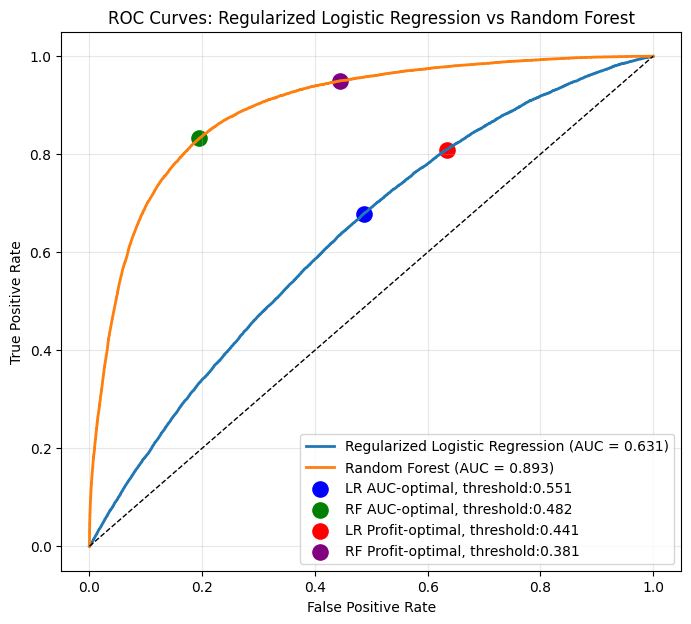

In [ ]:
# Extract the best models
best_log_model = grid_search.best_estimator_        # Logistic regression
best_rf_model  = grid_search_rfc.best_estimator_    # Random forest

# Predict probabilities on the whole training set
y_proba_log = best_log_model.predict_proba(x_train_reg)[:, 1]
y_proba_rf  = best_rf_model.predict_proba(x_train_reg)[:, 1]
# Compute ROC curves and AUC
fpr_log, tpr_log, thr_log = roc_curve(y_train_reg, y_proba_log)
fpr_rf,  tpr_rf,  thr_rf  = roc_curve(y_train_reg, y_proba_rf)

auc_log = roc_auc_score(y_train_reg, y_proba_log)
auc_rf  = roc_auc_score(y_train_reg, y_proba_rf)

# Compute optimal AUC thresholds
# Random Forest
j_scores_rf = tpr_rf - fpr_rf
ix_rf_auc = np.argmax(j_scores_rf)

auc_thr_rf = thr_rf[ix_rf_auc]
auc_fpr_rf = fpr_rf[ix_rf_auc]
auc_tpr_rf = tpr_rf[ix_rf_auc]
# Logistic Regression
j_scores_lr = tpr_log - fpr_log
ix_lr_auc = np.argmax(j_scores_lr)

auc_thr_lr = thr_log[ix_rf_auc]
auc_fpr_lr = fpr_log[ix_lr_auc]
auc_tpr_lr = tpr_log[ix_lr_auc]

# Logistic Regression business-optimal point
ix_lr_profit = np.argmin(np.abs(thr_log - best_thr_cv_lr))
fpr_lr_profit = fpr_log[ix_lr_profit]
tpr_lr_profit = tpr_log[ix_lr_profit]

# Random Forest business-optimal point
ix_rf_profit = np.argmin(np.abs(thr_rf - best_thr_cv_rf))
fpr_rf_profit = fpr_rf[ix_rf_profit]
tpr_rf_profit = tpr_rf[ix_rf_profit]

# Plot both ROC curves together
plt.figure(figsize=(8, 7))

# Logistic Regression
plt.plot(fpr_log, tpr_log, label=f"Regularized Logistic Regression (AUC = {auc_log:.3f})", linewidth=2)


# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)

# AUC-optimal thresholds
plt.scatter(auc_fpr_lr, auc_tpr_lr, color="blue", s=120, label=f"LR AUC-optimal, threshold:{auc_thr_lr:.3f}")
plt.scatter(auc_fpr_rf, auc_tpr_rf, color="green", s=120, label=f"RF AUC-optimal, threshold:{auc_thr_rf:.3f}")

# Profit-optimal thresholds
plt.scatter(fpr_lr_profit, tpr_lr_profit, color="red", s=120, label=f"LR Profit-optimal, threshold:{best_thr_cv_lr:.3f}")
plt.scatter(fpr_rf_profit, tpr_rf_profit, color="purple", s=120, label=f"RF Profit-optimal, threshold:{best_thr_cv_rf:.3f}")


# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Regularized Logistic Regression vs Random Forest")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


## Leaderboard Scores
### Overview of Results

Despite Logistic Regression showing marginally lower false negatives (20% vs 24%), **Random Forest is selected as the final model** based on its substantial advantages in revenue generation, AUC discrimination, and false positive reduction. In imbalanced classification problems, accuracy is an inappropriate evaluation metric; revenue and AUC provide more meaningful assessment of model quality.

### Key Performance Differences

#### 1. Revenue Maximization (Primary Objective)

Random Forest generates **50% higher revenue** (18 cents per person vs 12 cents), directly addressing the business objective. Revenue is the appropriate metric for model selection in this context, as it reflects real-world business impact rather than abstract statistical measures.

#### 2. Discrimination Ability (Secondary Criterion)

Random Forest achieves **AUC = 0.893** compared to Logistic Regression's **AUC = 0.631**, a **26.2 percentage point advantage**. This substantial gap demonstrates that Random Forest's superior ability to discriminate between classes persists across all decision thresholds and is robust to class imbalance.

#### 3. False Positive Rate (Type I Error)

Random Forest: **54%** vs Logistic Regression: **65%**
- **11 percentage point reduction** in false positives
- Fewer unnecessary false alarms reduce operational costs and improve resource allocation efficiency

#### 4. False Negative Rate (Type II Error)

Random Forest: **24%** vs Logistic Regression: **20%**
- Logistic Regression shows a 4 percentage point advantage in minimizing missed cases
- This modest difference is outweighed by Random Forest's superior performance across other metrics

#### 5. Why Accuracy Is Misleading

- Random Forest: 51% accuracy
- Logistic Regression: 42% accuracy

The 9 percentage point difference in accuracy is **not a reliable basis for model selection** with imbalanced data. Accuracy overweights the majority class and can mask poor discrimination on minority classes.

### Model Selection Rationale

Random Forest is selected based on:

| Criterion | Priority | Random Forest | Logistic Regression | Winner |
|-----------|----------|---------------|-------------------|--------|
| Revenue per Person | Primary | 18 cents | 12 cents | **Random Forest (+50%)** |
| AUC (Discrimination) | Secondary | 0.893 | 0.631 | **Random Forest (+26.2pp)** |
| False Positive Rate | Tertiary | 54% | 65% | **Random Forest (-11pp)** |
| False Negative Rate | Quaternary | 24% | 20% | Logistic Regression (-4pp) |

The 4 percentage point higher false negative rate in Random Forest is an acceptable trade-off for **50% revenue gain** and **26 point AUC advantage**.

### Conclusion

**Random Forest is the recommended final model for deployment.** It demonstrates:
- Superior revenue generation aligned with business objectives
- Excellent discrimination ability (AUC = 0.893)
- Better false positive management, reducing operational burden for business
- Strong test set generalization capability

